In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alchemist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alchemist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(4290, 4)


# Adding "TF-IDF" feature

In [4]:
train_qs = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [5]:
stops = set(stopwords.words("english"))


def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[3]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[4]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = train_df.apply(word_match_share, axis=1, raw=True)

Text(0.5,0,'word_match_share')

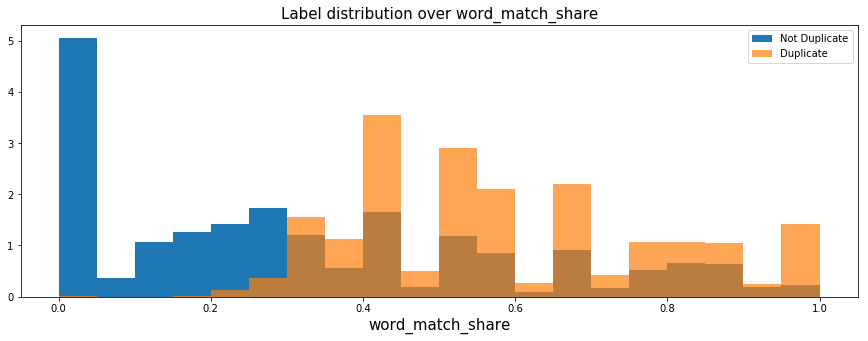

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(train_word_match[train_df['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(train_word_match[train_df['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [7]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[3]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[4]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = train_df.apply(tfidf_word_match_share, axis=1, raw=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,0,'word_match_share')

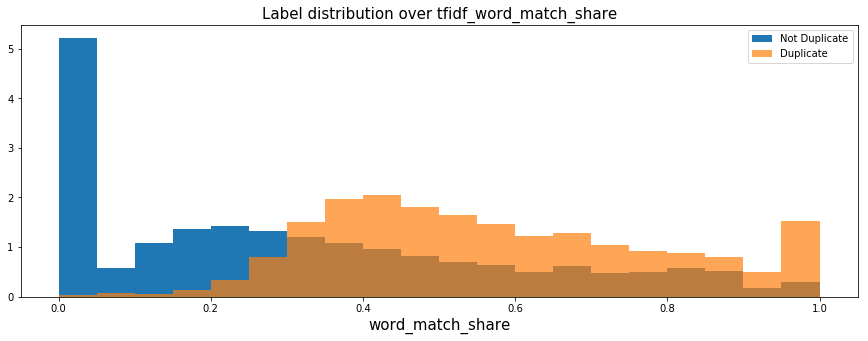

In [8]:
plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 0].fillna(0), bins=20, density=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 1].fillna(0), bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [9]:
def test_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [10]:
def test_tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [11]:
train_df['word_match'] = train_word_match
train_df['tfidf_word_match'] = tfidf_train_word_match
test_df['word_match'] = test_df.apply(test_word_match_share, axis=1, raw=True)
test_df['tfidf_word_match'] = test_df.apply(test_tfidf_word_match_share, axis=1, raw=True)

# Adding "unigrams" feature

In [12]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

test_df["unigrams_ques1"] = test_df['question1'].apply(lambda x: get_unigrams(str(x)))
test_df["unigrams_ques2"] = test_df['question2'].apply(lambda x: get_unigrams(str(x)))
test_df["unigrams_common_count"] = test_df.apply(lambda row: get_common_unigrams(row),axis=1)
test_df["unigrams_common_ratio"] = test_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

# Adding "Leaky Features" (frequency + intersection)

In [13]:
ques = pd.concat([train_df[['question1', 'question2']], \
        test_df[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(408580, 2)

In [14]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [15]:
def q1_freq(row):
    return(len(q_dict[row[3]]))
    
def q2_freq(row):
    return(len(q_dict[row[4]]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row[3]]).intersection(set(q_dict[row[4]]))))

train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect, axis=1, raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

In [16]:
def q1_freq_test(row):
    return(len(q_dict[row[1]]))
    
def q2_freq_test(row):
    return(len(q_dict[row[2]]))
    
def q1_q2_intersect_test(row):
    return(len(set(q_dict[row[1]]).intersection(set(q_dict[row[2]]))))

test_df['q1_q2_intersect'] = test_df.apply(q1_q2_intersect_test, axis=1, raw=True)
test_df['q1_freq'] = test_df.apply(q1_freq_test, axis=1, raw=True)
test_df['q2_freq'] = test_df.apply(q2_freq_test, axis=1, raw=True)

In [17]:
train_df.to_csv('train(unigrams + intersection + frequency).csv', index=False)
test_df.to_csv('test(unigrams + intersection + frequency).csv', index=False)

# Use XGBoost to test of the above features do increase accuracy

In [23]:
# Parameters:
# gpu_boost: If true, use GPU boost. Note: Using GPU boost may result in slight worse accuracy than using only CPU for calculation
# data_oversample: If true, make positive rate decrease from 0.369 to 0.17 (original test data has 0.17 positive rate), this should NOT make sense since we have used different test data and the positive rate in test data is the same as the training data
# objective_hinge: If true, make "accuracy" as the objective (achieve highest accuracy) and the output will be boolean values (0 or 1). If false, make "logloss" as the objective (achieve lowest logloss) and the output will be float values (between 0 and 1) and needs to be converted to boolean values (< 0.5 means 0 and 1 otherwise)
# output_csv: If true, output corresponding csv file. Note: May overwrite previous file, please double check before running

def xgb_model(gpu_boost = True, data_oversample = False, objective_hinge = True, output_csv = True):
    if data_oversample: 
        # Rebalance the data to make it closer to the test set
        pos_boostrap_sample = train_df[train_df["is_duplicate"] == 0].sample(n = 500000, replace = True)
        rebalanced_df = pd.concat((pos_boostrap_sample, train_df))
        print("Positive rate: {}%".format(round(rebalanced_df['is_duplicate'].value_counts()[1] / (rebalanced_df['is_duplicate'].value_counts()[0] + rebalanced_df['is_duplicate'].value_counts()[1]), 3)))
        
        x_train = pd.DataFrame()
        x_test = pd.DataFrame()
        y_train = pd.DataFrame()
        y_test = pd.DataFrame()

        x_train['unigrams_common_count'] = rebalanced_df['unigrams_common_count']
        x_train['unigrams_common_ratio'] = rebalanced_df['unigrams_common_ratio']
        x_train['q1_q2_intersect'] = rebalanced_df['q1_q2_intersect']
        x_train['q1_freq'] = rebalanced_df['q1_freq']
        x_train['q2_freq'] = rebalanced_df['q2_freq']
        x_train['word_match'] = rebalanced_df['word_match']
        x_train['tfidf_word_match'] = rebalanced_df['tfidf_word_match']

        x_test['unigrams_common_count'] = test_df['unigrams_common_count']
        x_test['unigrams_common_ratio'] = test_df['unigrams_common_ratio']
        x_test['q1_q2_intersect'] = test_df['q1_q2_intersect']
        x_test['q1_freq'] = test_df['q1_freq']
        x_test['q2_freq'] = test_df['q2_freq']
        x_test['word_match'] = test_df['word_match']
        x_test['tfidf_word_match'] = test_df['tfidf_word_match']

        y_train['is_duplicate'] = rebalanced_df['is_duplicate']
        y_test['is_duplicate (Ture Value)'] = test_df['is_duplicate (Ture Value)']
        
    else:
        print("Positive rate: {}%".format(round(train_df['is_duplicate'].value_counts()[1] / (train_df['is_duplicate'].value_counts()[0] + train_df['is_duplicate'].value_counts()[1]), 3)))
        x_train = pd.DataFrame()
        x_test = pd.DataFrame()
        y_train = pd.DataFrame()
        y_test = pd.DataFrame()

        x_train['unigrams_common_count'] = train_df['unigrams_common_count']
        x_train['unigrams_common_ratio'] = train_df['unigrams_common_ratio']
        x_train['q1_q2_intersect'] = train_df['q1_q2_intersect']
        x_train['q1_freq'] = train_df['q1_freq']
        x_train['q2_freq'] = train_df['q2_freq']
        x_train['word_match'] = train_df['word_match']
        x_train['tfidf_word_match'] = train_df['tfidf_word_match']

        x_test['unigrams_common_count'] = test_df['unigrams_common_count']
        x_test['unigrams_common_ratio'] = test_df['unigrams_common_ratio']
        x_test['q1_q2_intersect'] = test_df['q1_q2_intersect']
        x_test['q1_freq'] = test_df['q1_freq']
        x_test['q2_freq'] = test_df['q2_freq']
        x_test['word_match'] = test_df['word_match']
        x_test['tfidf_word_match'] = test_df['tfidf_word_match']

        y_train['is_duplicate'] = train_df['is_duplicate']
        y_test['is_duplicate (Ture Value)'] = test_df['is_duplicate (Ture Value)']
    
    # Finally, we split some of the data off for validation
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    params = {}
    
    # The following parameters may be fine-tuned in the future
    #params["eta"] = 0.02
    #params["gamma"] = 0
    #params["max_depth"] = 6
    #params["min_child_weight"] = 4
    #params["max_bin"] = 256
    #params["subsample"] = 0.8
    #params["colsample_bytree"] = 0.9

    if objective_hinge:
        params['objective'] = 'binary:hinge'
        params['eval_metric'] = 'error'
    else:
        params["objective"] = "binary:logistic"
        params["eval_metric"] = "logloss"

    if gpu_boost:
        params["tree_method"] = "gpu_hist"
        bst = xgb.train(params, d_train, 100000, watchlist, early_stopping_rounds=2000, verbose_eval=10)
    else:
        bst = xgb.train(params, d_train, 100000, watchlist, early_stopping_rounds=200, verbose_eval=10)
        
    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)
    
    if not objective_hinge:
        # Convert percentage to binary predictions
        result = []
        for i in p_test:
            if i < 0.5:
                result.append(0)
            else:
                result.append(1)
        result = np.array(result)
        sub = pd.DataFrame()
        sub['test_id'] = test_df['test_id']
        sub['is_duplicate'] = result
         
        # Get the accuracy on the test data
        true_values = test_df["is_duplicate (Ture Value)"]

        score = 0
        for i in range(0, len(result)):
            if result[i] == true_values.tolist()[i]:
                score = score + 1
        accuracy = score / len(result)
        print("Accuracy on test data: {}%".format(round(accuracy*100, 3)))
    else:
        sub = pd.DataFrame()
        sub['test_id'] = test_df['test_id']
        sub['is_duplicate'] = p_test
        
        # Get the accuracy on the test data
        true_values = test_df["is_duplicate (Ture Value)"]

        score = 0
        for i in range(0, len(p_test)):
            if p_test[i] == true_values.tolist()[i]:
                score = score + 1
        accuracy = score / len(p_test)
        print("Accuracy on test data: {}%".format(round(accuracy*100, 3)))
    
    file_name = 'xgb(unigrams + intersection + frequency)'
    if (gpu_boost):
        file_name = file_name + '(gpu_boost)'
    if (data_oversample):
        file_name = file_name + '(data_oversample)'
    if (objective_hinge):
        file_name = file_name + '(objective_accuracy)'
    else:
        file_name = file_name + '(objective_logloss)'
    
    if output_csv:
        sub.to_csv(file_name + '.csv', index=False)
    
   
    

In [25]:
xgb_model(gpu_boost = True, data_oversample = False, objective_hinge = True, output_csv = True)

Positive rate: 0.369%
[0]	train-error:0.63087	valid-error:0.63055
[10]	train-error:0.14433	valid-error:0.14423
[20]	train-error:0.13372	valid-error:0.13367
[30]	train-error:0.13356	valid-error:0.13341
[40]	train-error:0.13350	valid-error:0.13333
[50]	train-error:0.13340	valid-error:0.13327
[60]	train-error:0.13322	valid-error:0.13325
[70]	train-error:0.13305	valid-error:0.13334
[80]	train-error:0.13278	valid-error:0.13320
[90]	train-error:0.13264	valid-error:0.13314
[100]	train-error:0.13240	valid-error:0.13306
[110]	train-error:0.13233	valid-error:0.13290
[120]	train-error:0.13214	valid-error:0.13302
[130]	train-error:0.13213	valid-error:0.13287
[140]	train-error:0.13206	valid-error:0.13287
[150]	train-error:0.13205	valid-error:0.13295
[160]	train-error:0.13196	valid-error:0.13296
[170]	train-error:0.13195	valid-error:0.13296
[180]	train-error:0.13190	valid-error:0.13294
[190]	train-error:0.13166	valid-error:0.13300
[200]	train-error:0.13159	valid-error:0.13289
[210]	train-error:0.131

In [26]:
import winsound
winsound.Beep(500, 1000)